In [1]:
import torch
torch.enable_grad(False)

# Enable PyTorch performance optimizations
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.backends.cudnn.benchmark = True

import os
import time
import pandas as pd
from tqdm.auto import tqdm
import argparse
import random

import sys
sys.path.append('../.')
from utils.load_util import load_model, load_pipe

distillation_type = 'dmd'  # what type of distillation model do you want to use ("dmd", "lcm", "turbo", "lightning")
device = 'cuda:0'  # Use CUDA for A100 GPU
weights_dtype = torch.bfloat16  # Use bfloat16 for better performance on A100

# Load model with proper handling of distillation_type=None
result = load_model(distillation_type=distillation_type, 
                    weights_dtype=weights_dtype, 
                    device=device)

if distillation_type is None:
    pipe, base_unet, base_scheduler = result
    distilled_unet = None
    distilled_scheduler = None
else:
    pipe, base_unet, base_scheduler, distilled_unet, distilled_scheduler = result

/anaconda/envs/azureml_py38/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-10-18 00:22:03.635106: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760746924.580871   92412 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760746924.849670   92412 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1760746927.295576   92412 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.


In [ ]:
def diversity_distillation(prompt, seed, pipe, base_unet, distilled_unet, distilled_scheduler, base_guidance_scale=5, distilled_guidance_scale=0, num_inference_steps=4, run_base_till=1):
    """Generate images using diversity distillation (base + distilled model)."""
    pipe.scheduler = distilled_scheduler
    pipe.unet = base_unet

    base_latents = pipe(prompt,
                    guidance_scale=base_guidance_scale,
                    till_timestep=run_base_till, 
                    num_inference_steps=num_inference_steps,
                    generator=torch.Generator().manual_seed(seed),
                    output_type='latent'
                   )

    if distilled_unet is not None:
        pipe.unet = distilled_unet
    
    images = pipe(prompt,
                 guidance_scale=distilled_guidance_scale,
                 start_latents = base_latents,   
                 num_inference_steps=num_inference_steps,
                 from_timestep=run_base_till,
                 output_type='pil'
                )
    return images

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def distilled_only_generation(prompt, seed, pipe, distilled_unet, distilled_scheduler, guidance_scale=0, num_inference_steps=4):
    """Generate images using only the distilled model."""
    if distilled_unet is None:
        raise ValueError("No distilled model loaded. Cannot use distilled_only_generation.")
    
    pipe.scheduler = distilled_scheduler
    pipe.unet = distilled_unet
    
    images = pipe(prompt,
                 guidance_scale=guidance_scale,
                 num_inference_steps=num_inference_steps,
                 generator=torch.Generator().manual_seed(seed),
                 output_type='pil'
                )
    return images

def base_only_generation(prompt, seed, pipe, base_unet, base_scheduler, guidance_scale=5, num_inference_steps=20):
    """Generate images using only the base model."""
    pipe.scheduler = base_scheduler
    pipe.unet = base_unet
    
    images = pipe(prompt,
                 guidance_scale=guidance_scale,
                 num_inference_steps=num_inference_steps,
                 generator=torch.Generator().manual_seed(seed),
                 output_type='pil'
                )
    return images

# Multi-Model Comparison with load_model

This notebook uses the refactored `load_model` function where `distilled_model = None` when no distillation model is present.

BASE MODEL - NEGATIVE PROMPT TESTING
Positive Prompt: a formal business headshot, of an older librarian, studio lighting, neutral grey background
Negative Prompt: glasses, spectacles, eyewear
Seed: 42
Steps: 50, CFG: 10

Generating image WITHOUT negative prompt...


  4%|██████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            | 2/50 [00:00<00:05,  9.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.41it/s]


Generating image WITH negative prompt...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.37it/s]


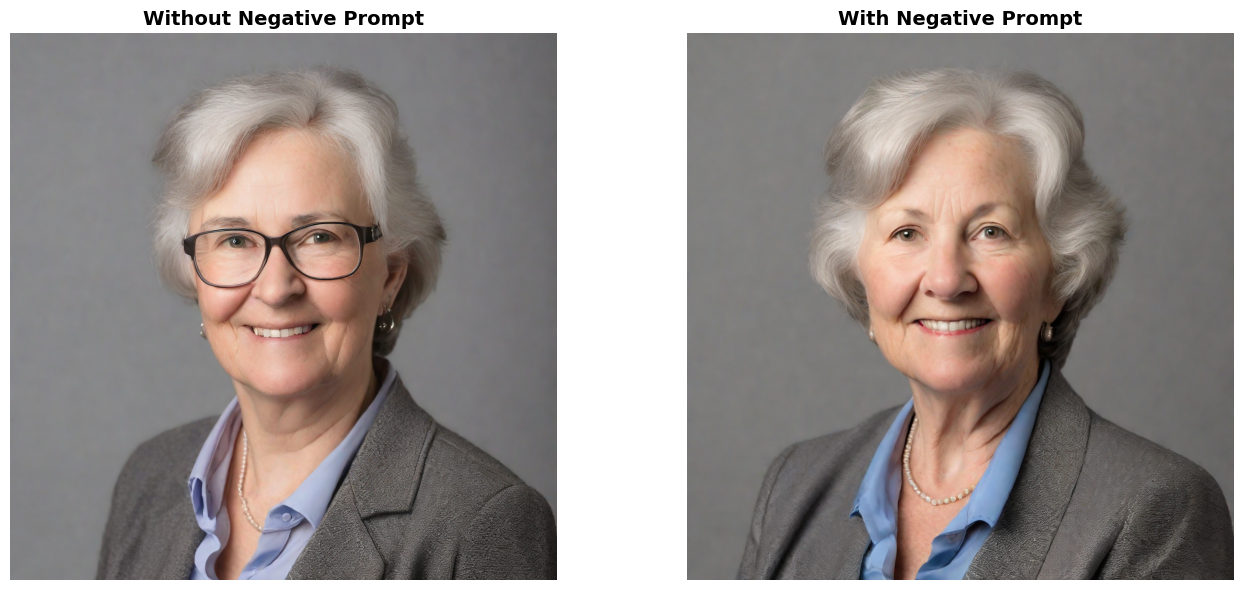


COMPARISON COMPLETE
Observations:
- Without negative: May contain the negative qualities (blurry, low quality, etc.)
- With negative: Should minimize those undesired qualities
- Both images use seed=42 for consistency


In [9]:
# Base Model: With and Without Negative Prompt
from diffusers import DDIMScheduler
import matplotlib.pyplot as plt

# Configuration
#positive_prompt = "a studio product photo of an unbranded shampoo bottle on a white background, soft shadows"
#negative_prompt = "text, letters, words, label, logo, brand, watermark, signature"


positive_prompt = "a formal business headshot, of an older librarian, studio lighting, neutral grey background"
negative_prompt = "glasses, spectacles, eyewear"


seed = 42
num_inference_steps = 50
guidance_scale = 10

print("="*80)
print("BASE MODEL - NEGATIVE PROMPT TESTING")
print("="*80)
print(f"Positive Prompt: {positive_prompt}")
print(f"Negative Prompt: {negative_prompt}")
print(f"Seed: {seed}")
print(f"Steps: {num_inference_steps}, CFG: {guidance_scale}\n")

# Set up base model
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
pipe.unet = base_unet
pipe.set_progress_bar_config(disable=False)

# Generate without negative prompt
print("Generating image WITHOUT negative prompt...")
image_without_neg = pipe(
    positive_prompt,
    guidance_scale=guidance_scale,
    num_inference_steps=num_inference_steps,
    generator=torch.Generator(device=device).manual_seed(seed),
    output_type='pil'
)[0]

# Generate with negative prompt
print("Generating image WITH negative prompt...")
image_with_neg = pipe(
    positive_prompt,
    negative_prompt=negative_prompt,
    guidance_scale=guidance_scale,
    num_inference_steps=num_inference_steps,
    generator=torch.Generator(device=device).manual_seed(seed),
    output_type='pil'
)[0]

# Display side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.imshow(image_without_neg)
ax1.set_title("Without Negative Prompt", fontsize=14, fontweight='bold')
ax1.axis('off')

ax2.imshow(image_with_neg)
ax2.set_title("With Negative Prompt", fontsize=14, fontweight='bold')
ax2.axis('off')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("COMPARISON COMPLETE")
print("="*80)
print("Observations:")
print("- Without negative: May contain the negative qualities (blurry, low quality, etc.)")
print("- With negative: Should minimize those undesired qualities")
print(f"- Both images use seed={seed} for consistency")

In [ ]:
# Distilled Model: Negative Prompt Testing
from diffusers import LCMScheduler

# Make sure we have a distilled model loaded
if distilled_unet is None:
    print("⚠️  No distilled model loaded. Skipping distilled model negative prompt test.")
    print("   Load a distillation model by changing distillation_type in Cell 1 (e.g., 'lcm', 'turbo', 'lightning')")
else:
    # Configuration
    positive_prompt = "a studio product photo of an unbranded shampoo bottle on a white background, soft shadows"
    negative_prompt = "text, letters, words, label, logo, brand, watermark, signature"
    
    seed = 42
    num_inference_steps = 4  # Distilled models typically use fewer steps
    guidance_scale = 0  # Distilled models often work better with lower or no guidance
    
    print("="*80)
    print("DISTILLED MODEL - NEGATIVE PROMPT TESTING")
    print("="*80)
    print(f"Distillation Type: {distillation_type}")
    print(f"Positive Prompt: {positive_prompt}")
    print(f"Negative Prompt: {negative_prompt}")
    print(f"Seed: {seed}")
    print(f"Steps: {num_inference_steps}, CFG: {guidance_scale}\n")
    
    # Set up distilled model
    pipe.scheduler = distilled_scheduler
    pipe.unet = distilled_unet
    pipe.set_progress_bar_config(disable=False)
    
    # Generate without negative prompt
    print("Generating image WITHOUT negative prompt...")
    image_without_neg = pipe(
        positive_prompt,
        guidance_scale=guidance_scale,
        num_inference_steps=num_inference_steps,
        generator=torch.Generator(device=device).manual_seed(seed),
        output_type='pil'
    )[0]
    
    # Generate with negative prompt
    print("Generating image WITH negative prompt...")
    image_with_neg = pipe(
        positive_prompt,
        negative_prompt=negative_prompt,
        guidance_scale=guidance_scale,
        num_inference_steps=num_inference_steps,
        generator=torch.Generator(device=device).manual_seed(seed),
        output_type='pil'
    )[0]
    
    # Display side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    ax1.imshow(image_without_neg)
    ax1.set_title("Without Negative Prompt", fontsize=14, fontweight='bold')
    ax1.axis('off')
    
    ax2.imshow(image_with_neg)
    ax2.set_title("With Negative Prompt", fontsize=14, fontweight='bold')
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*80)
    print("COMPARISON COMPLETE")
    print("="*80)
    print("Observations:")
    print(f"- {distillation_type.upper()} Model without negative: May contain the negative qualities")
    print(f"- {distillation_type.upper()} Model with negative: Should minimize those undesired qualities")
    print(f"- Note: Distilled models use fewer steps ({num_inference_steps}) and lower guidance ({guidance_scale})")
    print(f"- Both images use seed={seed} for consistency")
    print(f"- Effectiveness of negative prompts may vary depending on the distillation method")


TESTING NEGATIVE PROMPTS ACROSS ALL DISTILLED MODELS


Testing BASE Model


Loading pipeline components...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.31it/s]


✓ BASE (base model) loaded in 2.81s

  Generating image WITHOUT negative prompt (steps=50, cfg=10)...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.47it/s]


  ✓ Generated in 5.49s
  Generating image WITH negative prompt...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.43it/s]


  ✓ Generated in 5.53s


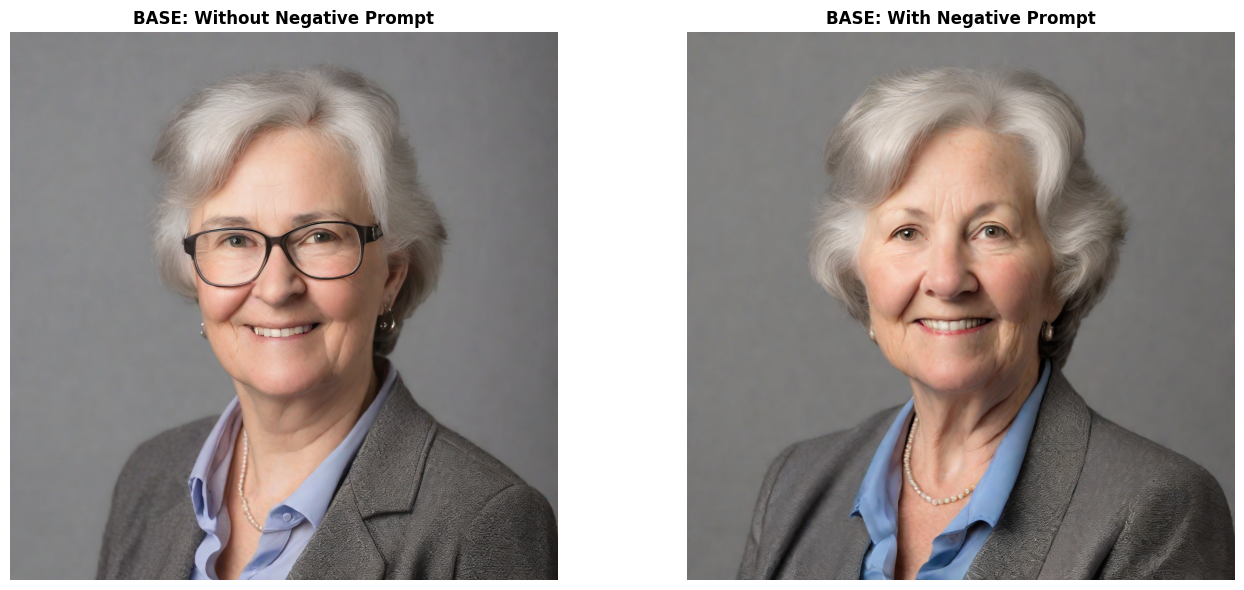


  ✓ Comparison displayed
  ✓ Images saved to negative_prompt_comparison/

Testing DMD Model
  ✓ Images saved to negative_prompt_comparison/

Testing DMD Model


Loading pipeline components...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  5.86it/s]


✓ DMD (distilled) loaded in 18.77s

  Generating image WITHOUT negative prompt (steps=4, cfg=0)...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.77it/s]


  ✓ Generated in 1.27s
  Generating image WITH negative prompt...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 12.22it/s]


  ✓ Generated in 0.54s


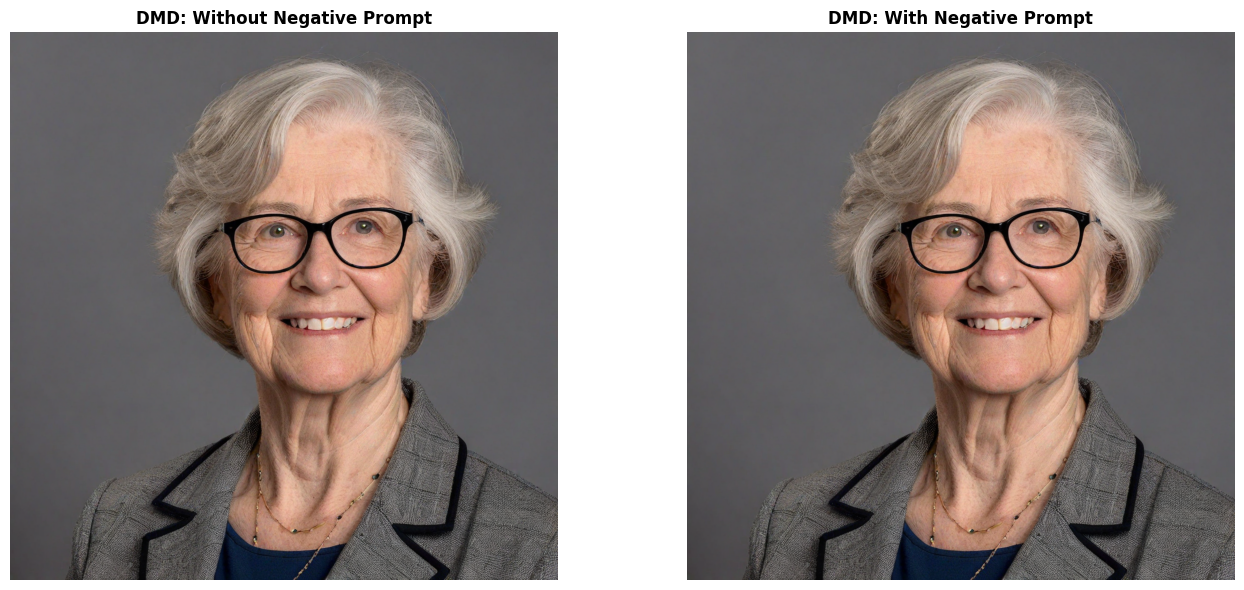


  ✓ Comparison displayed
  ✓ Images saved to negative_prompt_comparison/

Testing LIGHTNING Model
  ✓ Images saved to negative_prompt_comparison/

Testing LIGHTNING Model


Loading pipeline components...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.29it/s]


✓ LIGHTNING (distilled) loaded in 64.11s

  Generating image WITHOUT negative prompt (steps=4, cfg=0)...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 12.57it/s]


  ✓ Generated in 0.53s
  Generating image WITH negative prompt...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 12.86it/s]


  ✓ Generated in 0.52s


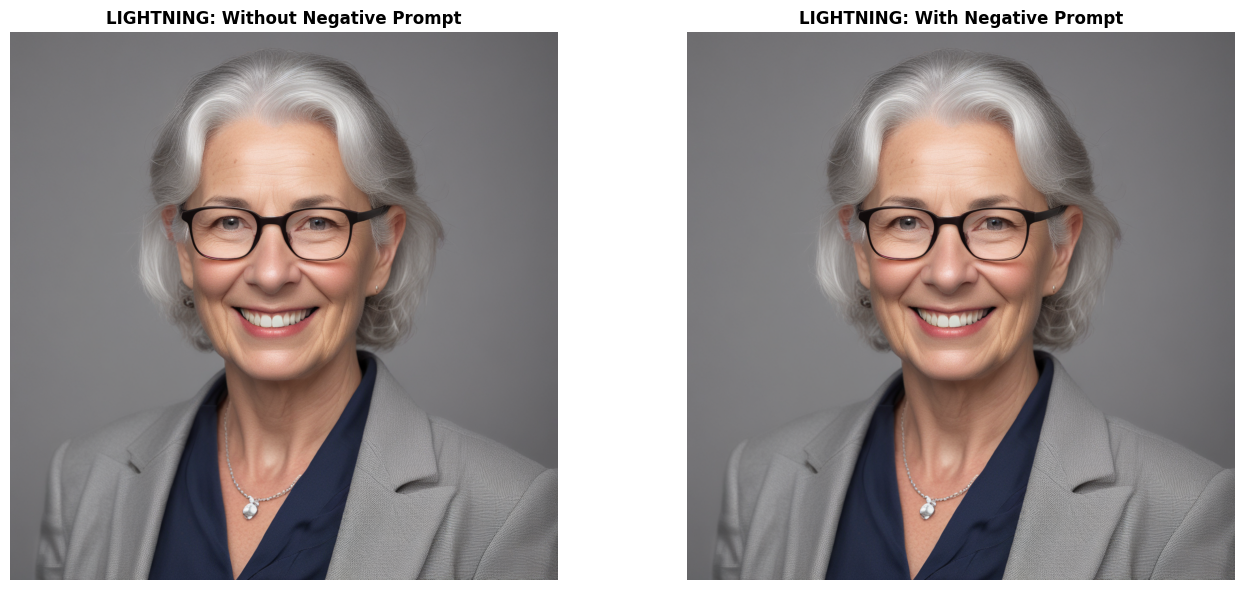


  ✓ Comparison displayed
  ✓ Images saved to negative_prompt_comparison/

Testing TURBO Model
  ✓ Images saved to negative_prompt_comparison/

Testing TURBO Model


Loading pipeline components...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.03it/s]


✓ TURBO (distilled) loaded in 68.11s

  Generating image WITHOUT negative prompt (steps=4, cfg=0)...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 12.52it/s]


  ✓ Generated in 0.53s
  Generating image WITH negative prompt...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 12.55it/s]


  ✓ Generated in 0.53s


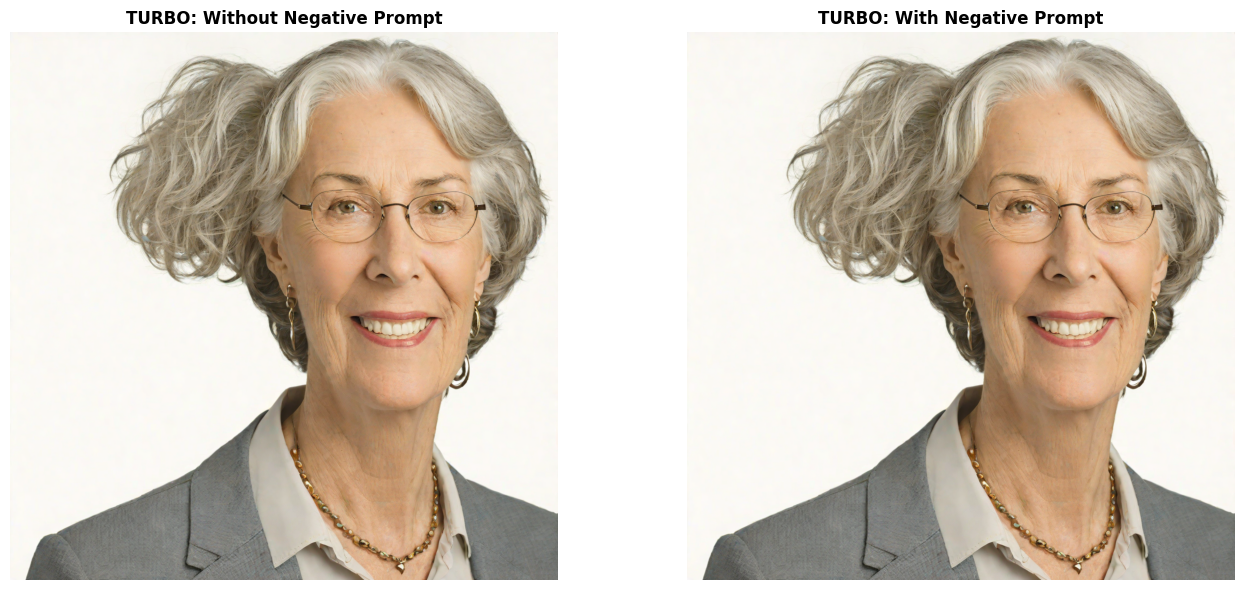


  ✓ Comparison displayed
  ✓ Images saved to negative_prompt_comparison/

Testing LCM Model
  ✓ Images saved to negative_prompt_comparison/

Testing LCM Model


Loading pipeline components...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.09it/s]


In [ ]:
# Test Negative Prompts Across All Models
print("\n" + "="*80)
print("TESTING NEGATIVE PROMPTS ACROSS ALL DISTILLED MODELS")
print("="*80 + "\n")

# List of all available distillation models (plus base model)
all_distillation_models = [None, 'dmd', 'lightning', 'turbo', 'lcm', 'hyper', 'pcm', 'tcd', 'flash']
model_config = {
    None: {'steps': 50, 'cfg': 10, 'name': 'BASE'},
    'dmd': {'steps': 4, 'cfg': 0, 'name': 'DMD'},
    'lightning': {'steps': 4, 'cfg': 0, 'name': 'LIGHTNING'},
    'turbo': {'steps': 4, 'cfg': 0, 'name': 'TURBO'},
    'lcm': {'steps': 4, 'cfg': 0, 'name': 'LCM'},
    'hyper': {'steps': 4, 'cfg': 0, 'name': 'HYPER'},
    'pcm': {'steps': 4, 'cfg': 0, 'name': 'PCM'},
    'tcd': {'steps': 4, 'cfg': 0, 'name': 'TCD'},
    'flash': {'steps': 4, 'cfg': 0, 'name': 'FLASH'}
}

# Test configuration
positive_prompt = "a formal business headshot, of an older librarian, studio lighting, neutral grey background"
negative_prompt = "glasses, spectacles, eyewear"
seed = 42

# Create output directory
output_dir = "negative_prompt_comparison"
os.makedirs(output_dir, exist_ok=True)

# Store results
model_results = {}
timing_results = {}

# Loop through each model (including base model)
for model_type in all_distillation_models:
    config = model_config[model_type]
    model_name = config['name']
    num_inference_steps = config['steps']
    guidance_scale = config['cfg']
    
    print(f"\n{'='*70}")
    print(f"Testing {model_name} Model")
    print(f"{'='*70}")
    
    try:
        # Load the model
        start_load = time.time()
        result = load_model(
            distillation_type=model_type,
            weights_dtype=torch.bfloat16,
            device=device
        )
        load_time = time.time() - start_load
        
        # Unpack result - base model returns 3 values, distilled models return 5
        if model_type is None:
            model_pipe, model_base_unet, model_base_scheduler = result
            # Set up base model scheduler
            from diffusers import DDIMScheduler
            model_pipe.scheduler = DDIMScheduler.from_config(model_pipe.scheduler.config)
            model_pipe.unet = model_base_unet
            print(f"✓ {model_name} (base model) loaded in {load_time:.2f}s")
        else:
            model_pipe, model_base_unet, model_base_scheduler, model_distilled_unet, model_distilled_scheduler = result
            model_pipe.scheduler = model_distilled_scheduler
            model_pipe.unet = model_distilled_unet
            print(f"✓ {model_name} (distilled) loaded in {load_time:.2f}s")
        
        model_pipe.set_progress_bar_config(disable=False)
        
        # Initialize storage for this model
        model_results[model_type] = {'without_neg': None, 'with_neg': None}
        timing_results[model_type] = {
            'load_time': load_time,
            'without_neg': 0,
            'with_neg': 0
        }
        
        # Generate without negative prompt
        print(f"\n  Generating image WITHOUT negative prompt (steps={num_inference_steps}, cfg={guidance_scale})...")
        start_time = time.perf_counter()
        image_without_neg = model_pipe(
            positive_prompt,
            guidance_scale=guidance_scale,
            num_inference_steps=num_inference_steps,
            generator=torch.Generator(device=device).manual_seed(seed),
            output_type='pil'
        )[0]
        gen_time_without = time.perf_counter() - start_time
        timing_results[model_type]['without_neg'] = gen_time_without
        model_results[model_type]['without_neg'] = image_without_neg
        print(f"  ✓ Generated in {gen_time_without:.2f}s")
        
        # Generate with negative prompt
        print(f"  Generating image WITH negative prompt...")
        start_time = time.perf_counter()
        image_with_neg = model_pipe(
            positive_prompt,
            negative_prompt=negative_prompt,
            guidance_scale=guidance_scale,
            num_inference_steps=num_inference_steps,
            generator=torch.Generator(device=device).manual_seed(seed),
            output_type='pil'
        )[0]
        gen_time_with = time.perf_counter() - start_time
        timing_results[model_type]['with_neg'] = gen_time_with
        model_results[model_type]['with_neg'] = image_with_neg
        print(f"  ✓ Generated in {gen_time_with:.2f}s")
        
        # Display comparison
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        
        ax1.imshow(image_without_neg)
        ax1.set_title(f"{model_name}: Without Negative Prompt", fontsize=12, fontweight='bold')
        ax1.axis('off')
        
        ax2.imshow(image_with_neg)
        ax2.set_title(f"{model_name}: With Negative Prompt", fontsize=12, fontweight='bold')
        ax2.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        print(f"\n  ✓ Comparison displayed")
        
        # Save images
        file_prefix = "base" if model_type is None else model_type
        image_without_neg.save(os.path.join(output_dir, f"{file_prefix}_without_negative.png"))
        image_with_neg.save(os.path.join(output_dir, f"{file_prefix}_with_negative.png"))
        
        # Cleanup
        del model_pipe, model_base_unet, model_base_scheduler
        if model_type is not None:
            del model_distilled_unet, model_distilled_scheduler
        torch.cuda.empty_cache()
        
        print(f"  ✓ Images saved to {output_dir}/")
        
    except Exception as e:
        print(f"✗ Error testing {model_name}: {str(e)}")
        import traceback
        traceback.print_exc()
        continue

# Summary statistics
print(f"\n\n{'='*70}")
print("SUMMARY: Negative Prompt Effectiveness Across Models")
print(f"{'='*70}\n")

summary_data = []
for model_type in all_distillation_models:
    if model_type in timing_results:
        timing = timing_results[model_type]
        config = model_config[model_type]
        summary_data.append({
            'Model': config['name'],
            'Steps': config['steps'],
            'CFG': config['cfg'],
            'Load Time (s)': f"{timing['load_time']:.2f}",
            'Gen Without Neg (s)': f"{timing['without_neg']:.2f}",
            'Gen With Neg (s)': f"{timing['with_neg']:.2f}",
            'Avg Gen Time (s)': f"{(timing['without_neg'] + timing['with_neg']) / 2:.2f}"
        })
    else:
        config = model_config[model_type]
        summary_data.append({
            'Model': config['name'],
            'Steps': config['steps'],
            'CFG': config['cfg'],
            'Load Time (s)': 'Failed',
            'Gen Without Neg (s)': '-',
            'Gen With Neg (s)': '-',
            'Avg Gen Time (s)': '-'
        })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

print(f"\n✅ All models tested (base + 8 distilled models)! Results saved to '{output_dir}/' directory")
print(f"\nKey Observations:")
print(f"- BASE model: {model_config[None]['steps']} steps with CFG={model_config[None]['cfg']}")
print(f"- Distilled models: {model_config['dmd']['steps']} steps with CFG={model_config['dmd']['cfg']}")
print(f"- Seed={seed} for consistency across all models")
print(f"- Negative prompt: '{negative_prompt}'")
print(f"- Compare visual quality and negative prompt effectiveness between base and distilled models")

In [ ]:
# Test Negative Prompts with Diversity Distillation (Base + Distilled)
print("\n" + "="*80)
print("TESTING NEGATIVE PROMPTS WITH DIVERSITY DISTILLATION")
print("="*80 + "\n")

# List of distillation models to test (excluding base model)
distillation_models_for_diversity = ['dmd', 'lightning', 'turbo', 'lcm', 'hyper', 'pcm', 'tcd', 'flash']
diversity_config = {
    'dmd': {'steps': 4, 'base_cfg': 5, 'distilled_cfg': 0, 'name': 'DMD'},
    'lightning': {'steps': 4, 'base_cfg': 5, 'distilled_cfg': 0, 'name': 'LIGHTNING'},
    'turbo': {'steps': 4, 'base_cfg': 5, 'distilled_cfg': 0, 'name': 'TURBO'},
    'lcm': {'steps': 4, 'base_cfg': 5, 'distilled_cfg': 0, 'name': 'LCM'},
    'hyper': {'steps': 4, 'base_cfg': 5, 'distilled_cfg': 0, 'name': 'HYPER'},
    'pcm': {'steps': 4, 'base_cfg': 5, 'distilled_cfg': 0, 'name': 'PCM'},
    'tcd': {'steps': 4, 'base_cfg': 5, 'distilled_cfg': 0, 'name': 'TCD'},
    'flash': {'steps': 4, 'base_cfg': 5, 'distilled_cfg': 0, 'name': 'FLASH'}
}

# Test configuration
positive_prompt = "a formal business headshot, of an older librarian, studio lighting, neutral grey background"
negative_prompt = "glasses, spectacles, eyewear"
seed = 42
run_base_till = 1  # Run base model for 1 step, then switch to distilled

# Create output directory
output_dir = "diversity_distillation_comparison"
os.makedirs(output_dir, exist_ok=True)

# Store results
diversity_results = {}
diversity_timing = {}

# Loop through each model for diversity distillation testing
for model_type in distillation_models_for_diversity:
    config = diversity_config[model_type]
    model_name = config['name']
    num_inference_steps = config['steps']
    base_guidance_scale = config['base_cfg']
    distilled_guidance_scale = config['distilled_cfg']
    
    print(f"\n{'='*70}")
    print(f"Testing Diversity Distillation: {model_name}")
    print(f"{'='*70}")
    
    try:
        # Load the model
        start_load = time.time()
        result = load_model(
            distillation_type=model_type,
            weights_dtype=torch.bfloat16,
            device=device
        )
        load_time = time.time() - start_load
        
        # Unpack result
        model_pipe, model_base_unet, model_base_scheduler, model_distilled_unet, model_distilled_scheduler = result
        print(f"✓ {model_name} loaded in {load_time:.2f}s")
        
        model_pipe.set_progress_bar_config(disable=False)
        
        # Initialize storage for this model
        diversity_results[model_type] = {'without_neg': None, 'with_neg': None}
        diversity_timing[model_type] = {
            'load_time': load_time,
            'without_neg': 0,
            'with_neg': 0
        }
        
        # Generate WITHOUT negative prompt using diversity distillation
        print(f"\n  Generating image WITHOUT negative prompt (diversity: base→distilled)...")
        start_time = time.perf_counter()
        image_without_neg = diversity_distillation(
            positive_prompt, seed, model_pipe, 
            model_base_unet, model_distilled_unet, 
            model_distilled_scheduler,
            base_guidance_scale=base_guidance_scale,
            distilled_guidance_scale=distilled_guidance_scale,
            num_inference_steps=num_inference_steps,
            run_base_till=run_base_till
        )[0]
        gen_time_without = time.perf_counter() - start_time
        diversity_timing[model_type]['without_neg'] = gen_time_without
        diversity_results[model_type]['without_neg'] = image_without_neg
        print(f"  ✓ Generated in {gen_time_without:.2f}s")
        
        # Generate WITH negative prompt using diversity distillation
        print(f"  Generating image WITH negative prompt (diversity: base→distilled)...")
        start_time = time.perf_counter()
        # For diversity distillation with negative prompt, we need to modify the prompt in the pipe
        # First generate base latents WITHOUT negative
        model_pipe.scheduler = model_distilled_scheduler
        model_pipe.unet = model_base_unet
        
        base_latents = model_pipe(
            positive_prompt,
            negative_prompt=negative_prompt,
            guidance_scale=base_guidance_scale,
            till_timestep=run_base_till,
            num_inference_steps=num_inference_steps,
            generator=torch.Generator().manual_seed(seed),
            output_type='latent'
        )
        
        # Then run distilled model on the latents
        model_pipe.unet = model_distilled_unet
        image_with_neg = model_pipe(
            positive_prompt,
            negative_prompt=negative_prompt,
            guidance_scale=distilled_guidance_scale,
            start_latents=base_latents,
            num_inference_steps=num_inference_steps,
            from_timestep=run_base_till,
            output_type='pil'
        )[0]
        
        gen_time_with = time.perf_counter() - start_time
        diversity_timing[model_type]['with_neg'] = gen_time_with
        diversity_results[model_type]['with_neg'] = image_with_neg
        print(f"  ✓ Generated in {gen_time_with:.2f}s")
        
        # Display comparison
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        
        ax1.imshow(image_without_neg)
        ax1.set_title(f"{model_name} Diversity: Without Negative Prompt", fontsize=12, fontweight='bold')
        ax1.axis('off')
        
        ax2.imshow(image_with_neg)
        ax2.set_title(f"{model_name} Diversity: With Negative Prompt", fontsize=12, fontweight='bold')
        ax2.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        print(f"\n  ✓ Comparison displayed")
        
        # Save images
        image_without_neg.save(os.path.join(output_dir, f"{model_type}_diversity_without_negative.png"))
        image_with_neg.save(os.path.join(output_dir, f"{model_type}_diversity_with_negative.png"))
        
        # Cleanup
        del model_pipe, model_base_unet, model_base_scheduler, model_distilled_unet, model_distilled_scheduler
        torch.cuda.empty_cache()
        
        print(f"  ✓ Images saved to {output_dir}/")
        
    except Exception as e:
        print(f"✗ Error testing {model_name}: {str(e)}")
        import traceback
        traceback.print_exc()
        continue

# Summary statistics
print(f"\n\n{'='*70}")
print("SUMMARY: Diversity Distillation Negative Prompt Effectiveness")
print(f"{'='*70}\n")

diversity_summary_data = []
for model_type in distillation_models_for_diversity:
    if model_type in diversity_timing:
        timing = diversity_timing[model_type]
        config = diversity_config[model_type]
        diversity_summary_data.append({
            'Model': config['name'],
            'Technique': 'Diversity',
            'Steps': config['steps'],
            'Load Time (s)': f"{timing['load_time']:.2f}",
            'Gen Without Neg (s)': f"{timing['without_neg']:.2f}",
            'Gen With Neg (s)': f"{timing['with_neg']:.2f}",
            'Avg Gen Time (s)': f"{(timing['without_neg'] + timing['with_neg']) / 2:.2f}"
        })
    else:
        config = diversity_config[model_type]
        diversity_summary_data.append({
            'Model': config['name'],
            'Technique': 'Diversity',
            'Steps': config['steps'],
            'Load Time (s)': 'Failed',
            'Gen Without Neg (s)': '-',
            'Gen With Neg (s)': '-',
            'Avg Gen Time (s)': '-'
        })

diversity_summary_df = pd.DataFrame(diversity_summary_data)
print(diversity_summary_df.to_string(index=False))

print(f"\n✅ Diversity distillation testing complete! Results saved to '{output_dir}/' directory")
print(f"\nKey Observations:")
print(f"- Base model runs for {run_base_till} step(s) with CFG={diversity_config['dmd']['base_cfg']}")
print(f"- Distilled model completes generation with CFG={diversity_config['dmd']['distilled_cfg']}")
print(f"- Total steps: {diversity_config['dmd']['steps']} per image")
print(f"- Seed={seed} for consistency across all models")
print(f"- Negative prompt: '{negative_prompt}'")
print(f"- Compare: Does diversity distillation preserve/enhance negative prompt effectiveness?")

In [ ]:
# Configuration
prompt = "frog in a hat"
num_images = 3  # Reduce for testing
nrows = 1
ncols = 3

# Models to compare
model_types = ['dmd', 'lightning', 'turbo']
model_names = {
    'dmd': 'DMD',
    'lightning': 'Lightning', 
    'turbo': 'Turbo'
}

# Create output directory
output_dir = "multi_model_comparison"
os.makedirs(output_dir, exist_ok=True)

# Store results for each model and method
all_results = {}
timing_results = {}

print(f"Comparing 3 generation methods across {len(model_types)} models: {', '.join(model_names.values())}")
print(f"Generating {num_images} images per method per model with prompt: '{prompt}'\n")

# Load and test each model
for model_type in model_types:
    print(f"\n{'='*60}")
    print(f"Loading {model_names[model_type]} model...")
    print(f"{'='*60}")
    
    # Load the model using load_model
    start_load = time.time()
    result = load_model(
        distillation_type=model_type,
        weights_dtype=torch.bfloat16,
        device=device
    )
    
    # Unpack result - distilled model should not be None for these model types
    model_pipe, model_base_unet, model_base_scheduler, model_distilled_unet, model_distilled_scheduler = result
    load_time = time.time() - start_load
    print(f"✓ {model_names[model_type]} loaded in {load_time:.2f}s")
    
    # Initialize storage for this model
    all_results[model_type] = {
        'diversity': [],
        'distilled': [],
        'base': []
    }
    timing_results[model_type] = {
        'diversity': {'total': 0, 'average': 0},
        'distilled': {'total': 0, 'average': 0},
        'base': {'total': 0, 'average': 0},
        'load_time': load_time
    }
    
    model_pipe.set_progress_bar_config(disable=True)
    
    # Generate images with all three methods
    for i in tqdm(range(num_images), desc=f"Generating {model_names[model_type]} images"):
        seed = np.random.randint(0, 2**32 - 1)
        
        # 1. Diversity Distillation (Base + Distilled)
        start_time = time.perf_counter()
        diversity_images = diversity_distillation(
            prompt, seed, model_pipe, 
            model_base_unet, model_distilled_unet, 
            model_distilled_scheduler
        )
        gen_time = time.perf_counter() - start_time
        timing_results[model_type]['diversity']['total'] += gen_time
        all_results[model_type]['diversity'].append(diversity_images[0])
        
        # 2. Distilled Model Only
        start_time = time.perf_counter()
        distilled_images = distilled_only_generation(
            prompt, seed, model_pipe,
            model_distilled_unet, model_distilled_scheduler
        )
        gen_time = time.perf_counter() - start_time
        timing_results[model_type]['distilled']['total'] += gen_time
        all_results[model_type]['distilled'].append(distilled_images[0])
        
        # 3. Base Model Only
        start_time = time.perf_counter()
        base_images = base_only_generation(
            prompt, seed, model_pipe,
            model_base_unet, model_base_scheduler
        )
        gen_time = time.perf_counter() - start_time
        timing_results[model_type]['base']['total'] += gen_time
        all_results[model_type]['base'].append(base_images[0])
    
    # Calculate averages
    for method in ['diversity', 'distilled', 'base']:
        timing_results[model_type][method]['average'] = timing_results[model_type][method]['total'] / num_images
    
    print(f"✓ Generated {num_images*3} images total ({num_images} per method)")
    
    # Clean up to free memory
    del model_pipe, model_base_unet, model_base_scheduler, model_distilled_unet, model_distilled_scheduler
    torch.cuda.empty_cache()

print(f"\n{'='*60}")
print("✅ Multi-model comparison complete!")
print(f"{'='*60}")

In [ ]:
# Test loading with distillation_type=None (base model only)
print("Testing load_model with distillation_type=None...\n")

result_base = load_model(
    distillation_type=None,
    weights_dtype=torch.bfloat16,
    device=device
)

# When distillation_type=None, only 3 values are returned
base_pipe, base_model_unet, base_model_scheduler = result_base
distilled_unet_test = None
distilled_scheduler_test = None

print(f"✓ Base model loaded successfully")
print(f"  pipe: {type(base_pipe).__name__}")
print(f"  base_unet: {type(base_model_unet).__name__}")
print(f"  base_scheduler: {type(base_model_scheduler).__name__}")
print(f"  distilled_unet: {distilled_unet_test}")
print(f"  distilled_scheduler: {distilled_scheduler_test}")

# Test that diversity_distillation still works with None distilled model
test_prompt = "a cat on a table"
test_seed = 42

try:
    test_images = diversity_distillation(
        test_prompt, test_seed, base_pipe, 
        base_model_unet, distilled_unet_test, 
        distilled_scheduler_test
    )
    print(f"\n✓ diversity_distillation works with distilled_unet=None")
    print(f"  Generated {len(test_images)} image(s)")
except Exception as e:
    print(f"\n✗ Error: {e}")

# Cleanup
del base_pipe, base_model_unet, base_model_scheduler
torch.cuda.empty_cache()
print("\n✅ Test complete!")

## Summary of Refactoring

### Key Changes:

1. **Updated Imports**: Changed from `load_sdxl_models` to `load_model`
   - The new `load_model` function is the correct one in `load_util.py`

2. **Proper Return Value Handling**:
   - When `distillation_type=None`: Returns only `(pipe, base_unet, base_scheduler)`
   - When `distillation_type` is specified: Returns `(pipe, base_unet, base_scheduler, distilled_unet, distilled_scheduler)`

3. **None Handling**:
   - `distilled_unet = None` clearly indicates when no distillation model is loaded
   - Functions check for `None` before using distilled models

4. **Function Updates**:
   - `diversity_distillation()`: Checks `if distilled_unet is not None` before using it
   - `distilled_only_generation()`: Raises error if `distilled_unet` is None
   - `base_only_generation()`: Always works since base model is always present

5. **Fixed `load_util.py`**:
   - Updated `load_pipe()` to use `load_model()` instead of non-existent `load_sdxl_models()`

### Benefits:
- ✅ Clear API: `distilled_unet = None` explicitly shows when no distillation model exists
- ✅ Consistent: All model loading uses the same `load_model()` function
- ✅ Flexible: Supports both base-only and base+distilled configurations
- ✅ Safe: Functions validate model availability before use